## Table of Contents:
* [Getting the Data](#first-bullet)
* [Exploring the Data](#second-bullet)
* [Processing the Data](#second-bullet)
* [Subset Selection](#second-bullet)
* [Logistic Regression](#second-bullet)
* [XG Boost](#second-bullet)

### Introduction
In this challenge. The company would like to understand which factors help determine whether a user will sign up for a subscription after signing up for a trial

### Takeaways:
1. XG Boost model performs best when optimizing for recall
2. It identifies that workout days and workout length are the most important features when trying to identify members who will sign up for a subscription 

### Load packages

In [2]:
import psycopg2

In [3]:
import pandas as pd

In [4]:
import statsmodels.api as sm

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
import numpy as np

In [132]:
import xgboost as xgb

In [157]:
from scipy import stats

In [83]:
from sklearn.model_selection import train_test_split, cross_val_score

# we will do a logistic regression:
from sklearn.linear_model import LogisticRegression

# we will evaluate how we our model works using accuracy:
from sklearn.metrics import accuracy_score, classification_report

In [7]:
from sklearn.model_selection import train_test_split

# we will do a logistic regression:
from sklearn.linear_model import LogisticRegression

# we will evaluate how we our model works using accuracy:
from sklearn.metrics import accuracy_score, classification_report

In [8]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

In [144]:
from sklearn.model_selection import GridSearchCV

In [9]:
import numpy as np

In [10]:
keepalive_kwargs = {
    "keepalives": 1,
    "keepalives_idle": 30,
    "keepalives_interval": 5,
    "keepalives_count": 5,
}

In [11]:
#Open connection to Redshift, needs to be run again every time
conn = psycopg2.connect(dbname ='peloton', host = 'prod-ds-product-analyst.onepeloton.sdm.network', port = '5439')
conn.set_session(readonly=False, autocommit=True)
cur = conn.cursor()

In [23]:
qry = '''
-- Activation of users on their first sub/trial when that first trial/sub is an App trial/sub 
-- Corp Wellness excluded 
-- Users who start trials but upgrade to all access subs post trial are also excluded
-- Adding marketing channel
with subs as (
    select 
    s.subscription_id,
    s.user_id,
    s.first_activated_at,
    s.subscription_tier,
    s.is_trial,
    s.product_id,
    case when s.first_activated_at < current_date - 33 then true else false end as upgrade_eligible,
    case when s.next_subscription_id is not null THEN 1 
    ELSE 0 
    END as upgraded_to_sub,
    store,
    s.next_subscription_tier,
    s.next_subscription_first_activated_at,
    s.next_subscription_id,
    row_number () over (partition by s.user_id order by s.first_activated_at asc) as sub_rank,
    case when s.is_trial = true and s.next_subscription_tier in ('all_access', 'guide') then true else false end as trial_to_hardware_sub
    from mart_subscription.mart_subscription s
    where s.is_excluded_from_reporting = false
    and s.subscription_tier in ('app_one_trial', 'app_plus_trial', 'app_legacy_trial')
    and (next_subscription_tier not in ('all_access', 'guide') or next_subscription_tier is null) -- exclude accidental AAM subs
    and s.first_activated_at >= '2023-03-01' -- date filter
    and (s.product_id not like '%gp%' or s.product_id is null) -- exclude guest pass
    and upgrade_eligible = true -- filter only trials that have had at least 33 days to convert or not
    and is_corporate_wellness = false -- no cw
    group by 1,2,3,4,5,6,7,8,9,10,11,12
    )

, max_sub_date as (
    SELECT
    s.subscription_id
    , s.user_id
    , s.first_activated_at
    , s.subscription_tier
    , s.upgraded_to_sub
    , s.next_subscription_id
    , MAX (p.month_start)
    , DATE_DIFF ('MONTH',s.first_activated_at,MAX(p.month_start)) as months_subscribed
    FROM subs s
    LEFT JOIN core_subscription.vw_subscription_monthly_payment_status p
        ON s.next_subscription_id = p.subscription_id
    WHERE sub_rank = 1
    AND status_at_month_start IN ('active','grace_period','paused')
    GROUP BY 1,2,3,4,5,6
)

, flags as (
    select 
    s.subscription_id 
    , s.user_id
    , s.first_activated_at
    , s.subscription_tier
    , s.is_trial
    , s.upgraded_to_sub
    , CASE
    WHEN months_subscribed >=1 THEN 1 ELSE 0
    END AS converted_to_m2
    , SUM (workout_length_minutes) as workout_length_minutes
    , count(w.workout_id) as total_num_workouts
    , count(distinct w.workout_dt::date) as total_num_workout_days
    , count(distinct case when w.workout_dt::date <= s.first_activated_at::date+6 then w.workout_dt::date end) as week_1_workout_days
    , count(distinct case when w.workout_dt::date > s.first_activated_at::date+6 and w.workout_dt::date <= s.first_activated_at::date+13 then w.workout_dt::date end) as week_2_workout_days
    , count(distinct case when w.workout_dt::date > s.first_activated_at::date+13 and w.workout_dt::date <= s.first_activated_at::date+20 then w.workout_dt::date end) as week_3_workout_days
    , count(distinct case when w.workout_dt::date > s.first_activated_at::date+20 and w.workout_dt::date <= s.first_activated_at::date+27 then w.workout_dt::date end) as week_4_workout_days
    , case when total_num_workouts >= 1 then true else false end as completed_first_workout_tf
    , case when week_1_workout_days + week_2_workout_days >= 1 then true else false end as completed_workout_in_first_14_days
    , case when week_1_workout_days >=1 and week_2_workout_days >=1 then true else false end as one_one_tf
    , case when week_1_workout_days >=2 and week_2_workout_days >=1 then true else false end as two_one_t
    from subs s 
    left join core_workout.workout w 
    -- if trial, only trial workouts; if sub, only workouts on that sub
    ON s.subscription_id = w.subscription_id
    AND w.workout_dt::date >= s.first_activated_at::date
    -- AND complete_10min_plus = true
    LEFT JOIN max_sub_date m
        ON m.subscription_id = s.subscription_id
    LEFT JOIN core_class.class c
        ON w.ride_id = c.class_id
    AND sub_rank = 1  
    GROUP by 1,2,3,4,5,6,7
)

, workout_length_by_discipline as (
SELECT
    subs.subscription_id
    , subs.user_id
    , w.subscription_type
    , c.browse_category
    -- , DATE_TRUNC ('month',workout_dt)::date as month
    , SUM (workout_length_minutes) as workout_length
from core_workout.workout w
left join core_class.class c
    on w.ride_id = c.class_id
INNER JOIN subs
    ON subs.subscription_id = w.subscription_id
group by 1,2,3,4
)

-- Rank most popular disciplines
, most_popular_discipline_helper as (
    SELECT subscription_id
    , user_id
    -- , month
    , browse_category
    , workout_length
    , ROW_NUMBER () OVER (PARTITION BY subscription_id ORDER BY workout_length DESC) discipline_rank
    FROM workout_length_by_discipline
)

-- Get 1st most popular discipline
, first_discipline as (
    SELECT subscription_id
    , user_id
    -- , month
    , browse_category as first_discipline
    , workout_length as first_discipline_length
    FROM most_popular_discipline_helper
    WHERE discipline_rank = 1
)

-- Get 2nd most popular discipline
, second_discipline as (
    SELECT subscription_id
    , user_id
    -- , month
    , browse_category as second_discipline
    , workout_length as second_discipline_length
    FROM most_popular_discipline_helper
    WHERE discipline_rank = 2
)

-- Get 3rd most popular discipline
, third_discipline as (
    SELECT subscription_id
    , user_id
    -- , month
    , browse_category as third_discipline
    , workout_length as third_discipline_length
    FROM most_popular_discipline_helper
    WHERE discipline_rank = 3
)

, workout_length_by_instructor as (
SELECT
    subs.subscription_id
    , subs.user_id
    , w.subscription_type
    , c.instructor_id
    , c.instructor
    -- , DATE_TRUNC ('month',workout_dt)::date as month
    , SUM (workout_length_minutes) as workout_length
from core_workout.workout w
left join core_class.class c
    on w.ride_id = c.class_id
INNER JOIN subs
    ON subs.subscription_id = w.subscription_id
group by 1,2,3,4,5
)

, most_popular_instructor_helper as (
    SELECT subscription_id
    , user_id
    -- , month
    , instructor_id
    , instructor
    , workout_length
    , ROW_NUMBER () OVER (PARTITION BY subscription_id ORDER BY workout_length DESC) instructor_rank
    FROM workout_length_by_instructor
)

-- Get 1st most popular discipline
, first_instructor as (
    SELECT subscription_id
    , user_id
    -- , month
    , instructor_id as first_instructor_id
    , instructor as first_instructor_name
    , workout_length as first_instructor_length
    FROM most_popular_instructor_helper
    WHERE instructor_rank = 1
) 


SELECT s.subscription_id 
    , s.user_id
    , s.first_activated_at
    , s.subscription_tier
    , s.is_trial
    , s.upgraded_to_sub
    , converted_to_m2
    , workout_length_minutes
    , total_num_workouts
    , total_num_workout_days
    , week_1_workout_days
    , week_2_workout_days
    , week_3_workout_days
    , week_4_workout_days
    , completed_first_workout_tf
    , completed_workout_in_first_14_days
    , one_one_tf
    , two_one_t
    , first_discipline
    , first_discipline_length
    , second_discipline_length
    , second_discipline
    , third_discipline_length
    , third_discipline
    , first_discipline_length/ NULLIF (workout_length_minutes,0) as top_discipline_capture
    , first_instructor_length/ NULLIF (workout_length_minutes,0) as top_instructor_capture
    , first_instructor_id
FROM flags s
LEFT JOIN first_discipline
    ON s.subscription_id = first_discipline.subscription_id
LEFT JOIN second_discipline
    ON s.subscription_id = second_discipline.subscription_id
LEFT JOIN third_discipline
    ON s.subscription_id = third_discipline.subscription_id
LEFT JOIN first_instructor
    ON s.subscription_id = first_instructor.subscription_id
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
'''

cur.execute(qry)
rows = cur.fetchall()
df = pd.DataFrame(list(rows), columns = [desc[0] for desc in cur.description])

### Clean up the data
1) Convert the dataframe columns to the right data types
2) Drop duplicative columns
3) Filter outliers
4) Remove data that don't pass data hygiene tests

In [13]:
df.head()

,subscription_id,user_id,first_activated_at,subscription_tier,is_trial,upgraded_to_sub,converted_to_m2,workout_length_minutes,total_num_workouts,total_num_workout_days,...,two_one_t,first_discipline,first_discipline_length,second_discipline_length,second_discipline,third_discipline_length,third_discipline,top_discipline_capture,top_instructor_capture,first_instructor_id
0,24f53264-be3f-4402-8fa7-456fa3efe126-trial,81dab5c1-9a61-4692-9b90-b71c7480b89b,2023-12-24 14:07:20,app_plus_trial,True,1,1,124.700000,5,4,...,True,Cycling,124.700000,NaN,None,NaN,None,1.000000,0.250735,731d7b7f-6b41-4a49-892c-21f01e25317d
1,49987d3b-ad46-4cfd-933b-d295318ffe82-trial,a23039bb-dce7-4248-858e-b143194b9233,2023-07-14 11:19:56,app_plus_trial,True,1,1,35.333333,2,2,...,False,Cycling,18.933333,16.400000,Meditation,NaN,None,0.535849,0.535849,c9bd86e5-9b9b-4f96-9818-48467838aa9c
2,812a86ea-b92d-4ea0-a75d-c42f04b9e21a,8ff7f773-c35c-4d36-af34-61627de889fc,2023-05-28 06:27:03,app_one_trial,True,0,0,119.066667,4,3,...,True,Cycling,119.066667,NaN,None,NaN,None,1.000000,1.000000,696bd08d-d528-4acc-ab06-5e2147b121d7
3,d302dc86-d8cf-44a7-bcc5-0ca5ac55fa28,141c293b-010e-45da-978b-cb6b0c278bbb,2024-01-20 05:22:18,app_plus_trial,True,0,0,134.866667,11,5,...,True,Cycling,119.900000,14.966667,Strength,NaN,None,0.889026,0.370489,696bd08d-d528-4acc-ab06-5e2147b121d7
4,ed0cef07-acd9-4c0d-8dd6-d009e4540182,0a0516e9-a179-4f16-8868-ad98d2b7d394,2024-03-16 22:00:08,app_plus_trial,True,0,0,NaN,0,0,...,False,None,NaN,NaN,None,NaN,None,NaN,NaN,None


In [24]:
df['subscription_tier'] = df['subscription_tier'].astype('category')
df['first_discipline'] = df['first_discipline'].astype('category')
df['second_discipline'] = df['second_discipline'].astype('category')
df['third_discipline'] = df['third_discipline'].astype('category')
df['first_instructor_id'] = df['first_instructor_id'].astype('category')

In [25]:
def preprocess_data(df):
    """
    Preprocesses a DataFrame by replacing numerical values with 0
    and categorical values with 'Not available'.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame
    
    Returns:
    - pd.DataFrame: Preprocessed DataFrame
    """
    processed_df = df.copy()  # Create a copy of the original DataFrame
    
    # Iterate over columns in the DataFrame
    for column in processed_df.columns:
        # Check the data type of the column
        if pd.api.types.is_numeric_dtype(processed_df[column]):
            # Replace numerical values with 0
            processed_df[column] = processed_df[column].fillna(0)
        elif pd.api.types.is_categorical_dtype(processed_df[column]):
            # Replace categorical values with 'Not available'
            # Create dummy variables for categorical values
            if 'NA' not in processed_df[column].cat.categories:
                processed_df[column] = processed_df[column].cat.add_categories('NA')
            processed_df[column] = processed_df[column].fillna('NA')
            processed_df = pd.get_dummies(processed_df, columns=[column])
    
    processed_df = processed_df.drop_duplicates()
    
    return processed_df

In [26]:
clean_data = preprocess_data(df)

In [42]:
columns_to_drop = ['completed_first_workout_tf','completed_workout_in_first_14_days','one_one_tf','two_one_t','subscription_id', 'user_id','first_activated_at','is_trial','converted_to_m2']

In [45]:
clean_data.drop(columns=columns_to_drop, inplace = True)

In [ ]:
clean_data.dtypes

### Insights from EDA
1) The sizes of each of these categories are well-balanced. ~55% of members that sign up for a trial convert to a paid subscription
2) ~30% of trialers that sign up for a subscription do not do a single workout. This could be because they intend to use the product in the future or more likely because they've forgotten to cancel their trial 

In [154]:
clean_data.describe()

,upgraded_to_sub,workout_length_minutes,total_num_workouts,total_num_workout_days,week_1_workout_days,week_2_workout_days,week_3_workout_days,week_4_workout_days,first_discipline_length,second_discipline_length,third_discipline_length,top_discipline_capture,top_instructor_capture,subscription_tier_app_legacy_trial,subscription_tier_app_one_trial,subscription_tier_app_plus_trial,subscription_tier_NA,first_discipline_Bike Bootcamp,first_discipline_Cardio,first_discipline_Cycling,first_discipline_Meditation,first_discipline_Outdoor,first_discipline_Row Bootcamp,first_discipline_Rowing,first_discipline_Running,first_discipline_Strength,first_discipline_Stretching,first_discipline_Tread Bootcamp,first_discipline_Walking,first_discipline_Yoga,first_discipline_NA,second_discipline_Bike Bootcamp,second_discipline_Cardio,second_discipline_Cycling,second_discipline_Meditation,second_discipline_Outdoor,second_discipline_Row Bootcamp,second_discipline_Rowing,second_discipline_Running,second_discipline_Strength,second_discipline_Stretching,second_discipline_Tread Bootcamp,second_discipline_Walking,second_discipline_Yoga,second_discipline_NA,third_discipline_Bike Bootcamp,third_discipline_Cardio,third_discipline_Cycling,third_discipline_Meditation,third_discipline_Outdoor,third_discipline_Row Bootcamp,third_discipline_Rowing,third_discipline_Running,third_discipline_Strength,third_discipline_Stretching,third_discipline_Tread Bootcamp,third_discipline_Walking,third_discipline_Yoga,third_discipline_NA,first_instructor_id_0021e222-0a79-40cf-94a7-647b1e4bae6c,first_instructor_id_017dd08b-0953-4697-9ddf-761eb49f9f67,first_instructor_id_01f636dc-54a1-4523-9c43-48e1736684ee,first_instructor_id_03ad1bf7-6a10-43a0-8f50-54925eecb089,first_instructor_id_040ab78d-62a7-4cfc-9954-c0e320815993,first_instructor_id_048f0ce0-0edb-4427-b2dc-ed6cbeb107fd,first_instructor_id_04aeec11-43fe-4e6d-9436-2c103b22dee8,first_instructor_id_05735e10-6f07-47d2-a112-d32678be8afd,first_instructor_id_096de802-dbb1-428b-95aa-e223b7364799,first_instructor_id_09ca61e7-2082-4073-b26c-36677fb15b0e,first_instructor_id_0ac29eff-d55a-435b-ad2f-5c07cab8e567,first_instructor_id_0d41a81a-64bc-4e38-866b-c01a0918020f,first_instructor_id_0e836f86-aa9c-4887-8245-2243f2e17170,first_instructor_id_0ebae5c5-0963-4ab0-b46e-1249f75cf37f,first_instructor_id_1423df9e-4ad6-4a84-a304-4d20a5c36563,first_instructor_id_15f01c91-45de-4d21-b58c-1a3e4e44a486,first_instructor_id_1697e6f5-8049-4740-a5a1-ca62b8b3f47c,first_instructor_id_16f7a0fa-5ee6-4e1f-8fc0-50c8a903ac9b,first_instructor_id_177747f7-f452-4d0f-8ff2-a03f2ed88050,first_instructor_id_1960c72e-6f0b-4ca1-a783-3b109616cddc,first_instructor_id_1994fcbc-168e-42e3-8b1f-06b0ef85bc31,first_instructor_id_1b79e462-bd56-4b6c-a5ec-728f1a5c2af0,first_instructor_id_1e59e949-a193-4153-9214-a4a13ea7ff01,first_instructor_id_1f4d39cd-181c-4805-a00c-d0a53f6c9562,first_instructor_id_23d0e395-f6b8-43ec-8a21-c0305bac4696,first_instructor_id_2532a869-b930-4a27-9bec-af39c9aae182,first_instructor_id_255c8178-2f72-42c9-a6ba-52e0a5f54912,first_instructor_id_286fc170-80d3-4406-a54b-80ad8ff83e12,first_instructor_id_2e1dd0ae-ae65-4d20-8cd8-ea0f6145440c,first_instructor_id_2e57092b-ee33-4c8c-8dcb-9fe16ba5308c,first_instructor_id_2eca274e-7a8b-48cb-9f34-dd10afbb3293,first_instructor_id_304389e2-bfe4-4830-854e-071bffc137c9,first_instructor_id_3126fe69-9a69-4198-82b9-6172ffbbe604,first_instructor_id_313df4bf-5c2f-4a08-ad55-5613d1ebd324,first_instructor_id_35016225-e39d-46db-bc36-4991ab48e10f,first_instructor_id_3543a358-2730-47c0-9542-db6ec1faba1f,first_instructor_id_38b7ce84-5993-42f6-bdff-dc7d00783b6c,first_instructor_id_3b18056a-292f-4de2-b69a-1f8254424785,first_instructor_id_3db293aa-704f-44ac-aff9-e94a4910f22c,first_instructor_id_3ff679eb-bd32-4c83-a8ab-6cfa6bb4be37,first_instructor_id_44e1e9cc-2a97-4a11-9758-0042f5a9d62e,first_instructor_id_4672db84-1da0-495c-af4b-8f9cda405512,first_instructor_id_46bb3042-c246-49b5-a64b-9add297dd090,first_instructor_id_49046129-6516-4231

From the summary above, it looks like I have some outliers

In [167]:
# Assuming clean_data is your DataFrame
columns_to_check = ['workout_length_minutes', 'total_num_workouts', 'total_num_workout_days']

# Calculate Z-scores for the specified columns
z_scores = stats.zscore(clean_data[columns_to_check])

# Convert Z-scores to a DataFrame for easier manipulation
z_scores_df = pd.DataFrame(z_scores, columns=columns_to_check)

# Define a threshold for Z-scores
threshold = 3

# Identify outliers based on the threshold
outliers = (np.abs(z_scores_df) > threshold).any(axis=1)

It also seemed like I had some data that didnt make sense like a user having some workouts but no workout length

In [185]:
def check_pattern(row):
    for column in columns_to_check:
        if row[column] == 0:
            # Check if all other columns are non-zero
            if all(row[other_column] != 0 for other_column in columns_to_check if other_column != column):
                return True
    return False

In [190]:
# Apply the function to each row and filter the dataframe
pattern_rows = clean_data.apply(check_pattern, axis=1)

In [192]:
clean_data = clean_data[~pattern_rows]

In [169]:
clean_data = clean_data[~outliers]

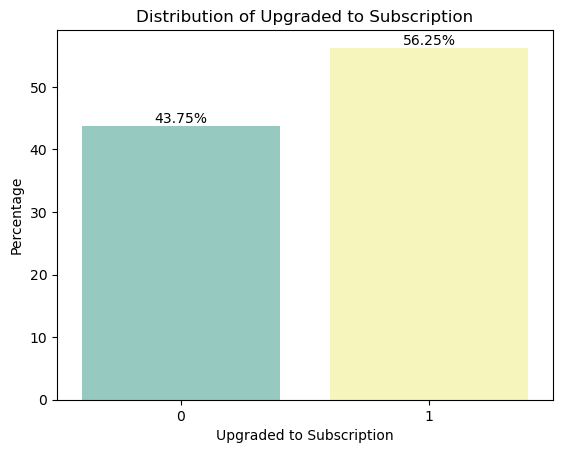

In [170]:
# Count the occurrences of each value in the target variable
value_counts = clean_data['upgraded_to_sub'].value_counts(normalize=True).reset_index()

# Rename columns for clarity
value_counts.columns = ['upgraded_to_sub', 'percentage']

# Convert percentage to actual percentage
value_counts['percentage'] *= 100

# Create bar plot using seaborn
sns.set_palette(sns.color_palette('Set3'))
ax = sns.barplot(x='upgraded_to_sub', y='percentage', data=value_counts)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add labels and title
plt.xlabel('Upgraded to Subscription')
plt.ylabel('Percentage')
plt.title('Distribution of Upgraded to Subscription')

# Show plot
plt.show()

###### 

By looking at the workout distribution of members in the data, you can see that many people don't do a single workout during the trial. Even many members that do sign up for a subscription end up converting to trial. I hypothesize that this is because they forget to cancel their trial

In [178]:
# Filter the dataframe to include only rows where upgraded_to_sub = 1
filtered_data = clean_data[clean_data['upgraded_to_sub'] == 1]

In [171]:
columns_to_plot = ['workout_length_minutes', 'total_num_workouts', 'total_num_workout_days']

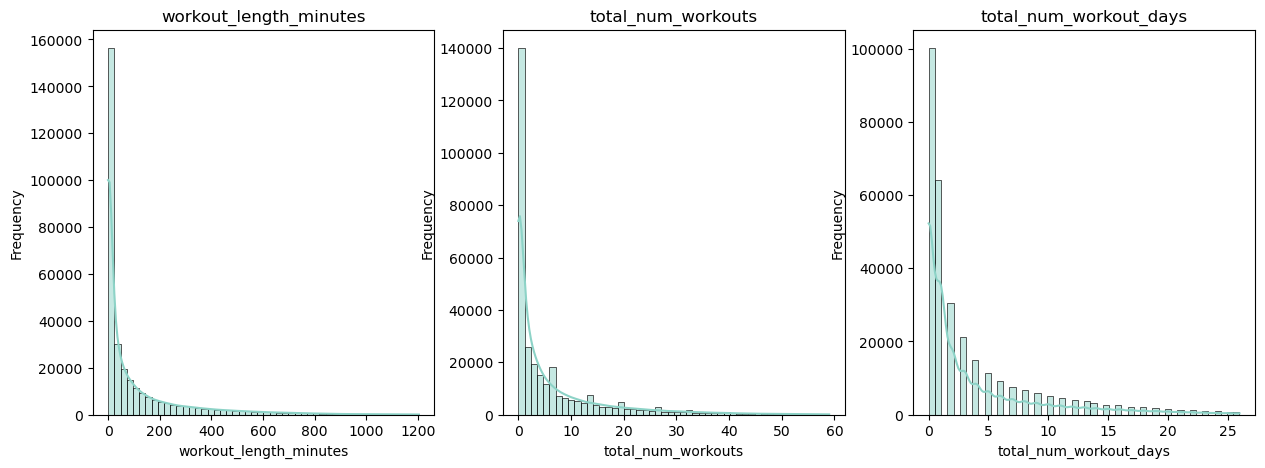

In [177]:
# Many members who sign up for a trial do 0 workouts
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 5))

for ax, column in zip(axes, columns_to_plot):
    sns.histplot(clean_data[column], bins=50, kde=True, ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

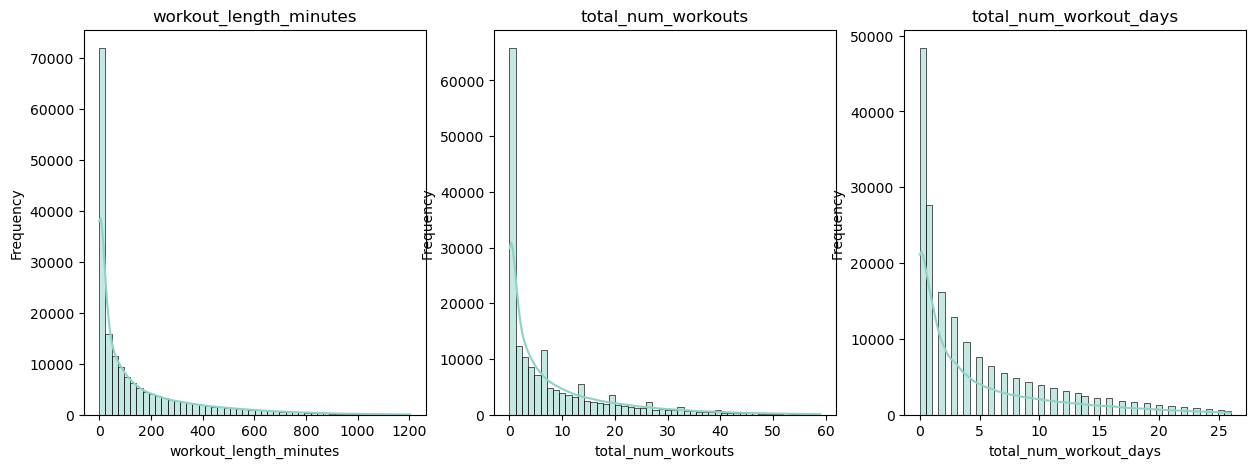

In [179]:
# Even many members who sign up for a subscription do 0 workouts
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 5))

for ax, column in zip(axes, columns_to_plot):
    sns.histplot(filtered_data[column], bins=50, kde=True, ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

In [278]:
len(filtered_data[filtered_data['total_num_workout_days'] == 0])/len(filtered_data)

0.27733192699257087

In [280]:
len(clean_data[clean_data['total_num_workout_days'] == 0])/len(clean_data)

0.3312636176382097

### Logistic Regression

In [200]:
clean_data.head()

,upgraded_to_sub,workout_length_minutes,total_num_workouts,total_num_workout_days,week_1_workout_days,week_2_workout_days,week_3_workout_days,week_4_workout_days,first_discipline_length,second_discipline_length,third_discipline_length,top_discipline_capture,top_instructor_capture,subscription_tier_app_legacy_trial,subscription_tier_app_one_trial,subscription_tier_app_plus_trial,subscription_tier_NA,first_discipline_Bike Bootcamp,first_discipline_Cardio,first_discipline_Cycling,first_discipline_Meditation,first_discipline_Outdoor,first_discipline_Row Bootcamp,first_discipline_Rowing,first_discipline_Running,first_discipline_Strength,first_discipline_Stretching,first_discipline_Tread Bootcamp,first_discipline_Walking,first_discipline_Yoga,first_discipline_NA,second_discipline_Bike Bootcamp,second_discipline_Cardio,second_discipline_Cycling,second_discipline_Meditation,second_discipline_Outdoor,second_discipline_Row Bootcamp,second_discipline_Rowing,second_discipline_Running,second_discipline_Strength,second_discipline_Stretching,second_discipline_Tread Bootcamp,second_discipline_Walking,second_discipline_Yoga,second_discipline_NA,third_discipline_Bike Bootcamp,third_discipline_Cardio,third_discipline_Cycling,third_discipline_Meditation,third_discipline_Outdoor,third_discipline_Row Bootcamp,third_discipline_Rowing,third_discipline_Running,third_discipline_Strength,third_discipline_Stretching,third_discipline_Tread Bootcamp,third_discipline_Walking,third_discipline_Yoga,third_discipline_NA,first_instructor_id_0021e222-0a79-40cf-94a7-647b1e4bae6c,first_instructor_id_017dd08b-0953-4697-9ddf-761eb49f9f67,first_instructor_id_01f636dc-54a1-4523-9c43-48e1736684ee,first_instructor_id_03ad1bf7-6a10-43a0-8f50-54925eecb089,first_instructor_id_040ab78d-62a7-4cfc-9954-c0e320815993,first_instructor_id_048f0ce0-0edb-4427-b2dc-ed6cbeb107fd,first_instructor_id_04aeec11-43fe-4e6d-9436-2c103b22dee8,first_instructor_id_05735e10-6f07-47d2-a112-d32678be8afd,first_instructor_id_096de802-dbb1-428b-95aa-e223b7364799,first_instructor_id_09ca61e7-2082-4073-b26c-36677fb15b0e,first_instructor_id_0ac29eff-d55a-435b-ad2f-5c07cab8e567,first_instructor_id_0d41a81a-64bc-4e38-866b-c01a0918020f,first_instructor_id_0e836f86-aa9c-4887-8245-2243f2e17170,first_instructor_id_0ebae5c5-0963-4ab0-b46e-1249f75cf37f,first_instructor_id_1423df9e-4ad6-4a84-a304-4d20a5c36563,first_instructor_id_15f01c91-45de-4d21-b58c-1a3e4e44a486,first_instructor_id_1697e6f5-8049-4740-a5a1-ca62b8b3f47c,first_instructor_id_16f7a0fa-5ee6-4e1f-8fc0-50c8a903ac9b,first_instructor_id_177747f7-f452-4d0f-8ff2-a03f2ed88050,first_instructor_id_1960c72e-6f0b-4ca1-a783-3b109616cddc,first_instructor_id_1994fcbc-168e-42e3-8b1f-06b0ef85bc31,first_instructor_id_1b79e462-bd56-4b6c-a5ec-728f1a5c2af0,first_instructor_id_1e59e949-a193-4153-9214-a4a13ea7ff01,first_instructor_id_1f4d39cd-181c-4805-a00c-d0a53f6c9562,first_instructor_id_23d0e395-f6b8-43ec-8a21-c0305bac4696,first_instructor_id_2532a869-b930-4a27-9bec-af39c9aae182,first_instructor_id_255c8178-2f72-42c9-a6ba-52e0a5f54912,first_instructor_id_286fc170-80d3-4406-a54b-80ad8ff83e12,first_instructor_id_2e1dd0ae-ae65-4d20-8cd8-ea0f6145440c,first_instructor_id_2e57092b-ee33-4c8c-8dcb-9fe16ba5308c,first_instructor_id_2eca274e-7a8b-48cb-9f34-dd10afbb3293,first_instructor_id_304389e2-bfe4-4830-854e-071bffc137c9,first_instructor_id_3126fe69-9a69-4198-82b9-6172ffbbe604,first_instructor_id_313df4bf-5c2f-4a08-ad55-5613d1ebd324,first_instructor_id_35016225-e39d-46db-bc36-4991ab48e10f,first_instructor_id_3543a358-2730-47c0-9542-db6ec1faba1f,first_instructor_id_38b7ce84-5993-42f6-bdff-dc7d00783b6c,first_instructor_id_3b18056a-292f-4de2-b69a-1f8254424785,first_instructor_id_3db293aa-704f-44ac-aff9-e94a4910f22c,first_instructor_id_3ff679eb-bd32-4c83-a8ab-6cfa6bb4be37,first_instructor_id_44e1e9cc-2a97-4a11-9758-0042f5a9d62e,first_instructor_id_4672db84-1da0-495c-af4b-8f9cda405512,first_instructor_id_46bb3042-c246-49b5-a64b-9add297dd090,first_instructor_id_49046129-6516-4231

In [201]:
y = clean_data['upgraded_to_sub']

In [202]:
X = clean_data.drop(columns='upgraded_to_sub')

In [203]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [204]:
print(X.shape,y.shape)

(302457, 172) (302457,)


In [287]:
# split the data into training and test sets,
# 80% for training, 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

In [288]:
# further split the training data into training and validation sets,
# 75% of the available data for training and 25% for validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [290]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(181473, 172)
(60492, 172)
(60492, 172)


In [291]:
# Step 4: Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [293]:
# Step 5: Cross-validation on the validation set
cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
print("Cross-Validation Scores on Validation Set:", cv_scores)
print("Mean CV Score on Validation Set:", np.mean(cv_scores))

Cross-Validation Scores on Validation Set: [0.61925885 0.61870781 0.61994765 0.62335372 0.6191657 ]
Mean CV Score on Validation Set: 0.6200867475929175


In [295]:
# Assuming you have trained a logistic regression model and made predictions
predictions = logistic_model.predict(X_test)

# Generate classification report
report = classification_report(y_test, predictions)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56     26279
           1       0.66      0.66      0.66     34213

    accuracy                           0.62     60492
   macro avg       0.61      0.61      0.61     60492
weighted avg       0.62      0.62      0.62     60492



In [308]:
test_score = logistic_model.score(X_test, y_test)
print("Test Set Score:", f"{test_score*100}%")
print ("Compared to random, this model is better by", f"{(test_score - (.56**2 + .44**2))*100}%")

Test Set Score: 61.6081465317728%
Compared to random, this model is better by 10.88814653177279%


Since this model performs only somewhat better than random. Maybe we can try and isolate the most important variables and see if that helps

### Subset Selection with Lasso

In [118]:
alphas = np.logspace(-4, 1, 10)

In [352]:
coefficients_lasso = []

In [120]:
alpha_zero = {feature: np.inf for feature in feature_names}

In [121]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs = lasso.coef_
    for i, coef in enumerate(coefs):
        if coef == 0 and alpha_zero[feature_names[i]] == np.inf:
            alpha_zero[feature_names[i]] = alpha

/Users/shaun.dsouza/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+02, tolerance: 7.825e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shaun.dsouza/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e+01, tolerance: 7.825e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shaun.dsouza/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

In [125]:
# Convert the dictionary to a DataFrame and sort by alpha
alpha_zero_df = pd.DataFrame(list(alpha_zero.items()), columns=['Feature', 'Alpha_Zero'])
alpha_zero_df.sort_values(by='Alpha_Zero', inplace=True,ascending = False)

In [141]:
alpha_zero_df.head(10)

,Feature,Alpha_Zero
8,second_discipline_length,2.782559
2,total_num_workout_days,0.774264
7,first_discipline_length,0.774264
0,workout_length_minutes,0.215443
3,week_1_workout_days,0.059948
4,week_2_workout_days,0.059948
5,week_3_workout_days,0.059948
6,week_4_workout_days,0.059948
1,total_num_workouts,0.059948
14,subscription_tier_app_plus_trial,0.059948


In [102]:
coefficients_lasso.shape

(300, 172)

Working out seems to be the most important predictor, but this pattern is obfuscated by members who sign up for their subscription because they forget to cancel their membership. Let's try making a model just for members that use the product to see if that helps

In [309]:
active_users = clean_data[clean_data['total_num_workouts']!=0]

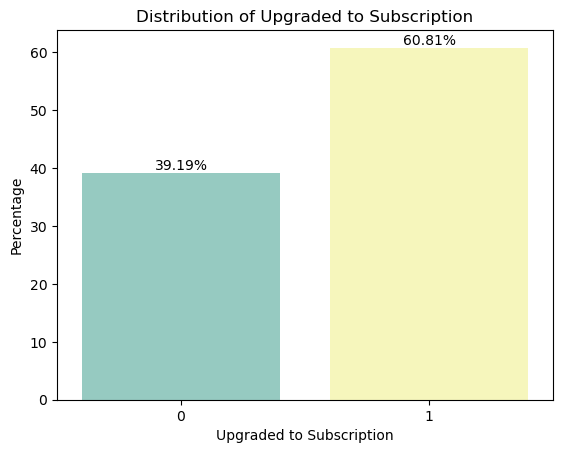

In [310]:
# Count the occurrences of each value in the target variable
value_counts = active_users['upgraded_to_sub'].value_counts(normalize=True).reset_index()

# Rename columns for clarity
value_counts.columns = ['upgraded_to_sub', 'percentage']

# Convert percentage to actual percentage
value_counts['percentage'] *= 100

# Create bar plot using seaborn
sns.set_palette(sns.color_palette('Set3'))
ax = sns.barplot(x='upgraded_to_sub', y='percentage', data=value_counts)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add labels and title
plt.xlabel('Upgraded to Subscription')
plt.ylabel('Percentage')
plt.title('Distribution of Upgraded to Subscription')

# Show plot
plt.show()

We still see that these categories are reasonably well balanced

In [228]:
y_active = active_users['upgraded_to_sub']

In [229]:
X_active = active_users.drop(columns='upgraded_to_sub')

In [230]:
scaler = StandardScaler()
X_active_standardized = scaler.fit_transform(X_active)

In [231]:
print(X_active.shape,y_active.shape)

(202264, 172) (202264,)


In [312]:
# split the data into training and test sets,
# 80% for training, 20% for test
X_active_temp, X_active_test, y_active_temp, y_active_test = train_test_split(X_active_standardized, y_active, test_size=0.2, random_state=42)

In [315]:
# further split the training data into training and validation sets,
# 75% of the available data for training and 25% for validation
X_active_train, X_active_val, y_active_train, y_active_val = train_test_split(X_active_temp, y_active_temp, test_size=0.25, random_state=42)

In [316]:
print(X_active_train.shape)
print(X_active_val.shape)
print(X_active_test.shape)

(121358, 172)
(40453, 172)
(40453, 172)


In [317]:
# Step 4: Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_active_train, y_active_train)

LogisticRegression()

In [318]:
# Step 5: Cross-validation on the validation set
cv_active_scores = cross_val_score(logistic_model, X_active_train, y_active_train, cv=5)
print("Cross-Validation Scores on Validation Set:", cv_active_scores)
print("Mean CV Score on Validation Set:", np.mean(cv_active_scores))

Cross-Validation Scores on Validation Set: [0.65524061 0.64745386 0.65004944 0.65600923 0.65349594]
Mean CV Score on Validation Set: 0.6524498146437934


In [319]:
test_score_logistic = logistic_model.score(X_active_test, y_active_test)
print("Test Set Score:", f"{test_score_logistic*100}%")
print ("Compared to random, this model is better by", f"{(test_score - (.6**2 + .4**2))*100}%")

Test Set Score: 65.19417595728376%
Compared to random, this model is better by 9.6081465317728%


In [245]:
# Assuming you have trained a logistic regression model and made predictions
predictions = logistic_model.predict(X_active_test)

# Generate classification report
report = classification_report(y_active_test, predictions)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      3947
           1       0.67      0.83      0.74      6167

    accuracy                           0.65     10114
   macro avg       0.63      0.60      0.60     10114
weighted avg       0.64      0.65      0.63     10114



But we do see that the recall for the subscription category improves significantly

### XG Boost

XG Boost outperforms a logsitic regression

In [337]:
#first, I'm going to try and tune the model
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [10,100,500]
#     subsample=0.8,
#     colsample_bytree=0.8,
#     verbosity=1
    # Add more parameters to tune here
}

In [338]:
grid_search.fit(X_active_train, y_active_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7]},
             scoring='accuracy')

In [339]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5}


In [340]:
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Cross-Validation Score: 0.6626510231494751


In [344]:
best_params = grid_search.best_params_

In [346]:
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_active_train, y_active_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [259]:
xgbmodel.fit(X_active_train, y_active_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [348]:
y_active_pred = final_model.predict(X_active_test)

In [349]:
# Evaluate the model
accuracy = accuracy_score(y_active_test, y_active_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_active_test, y_active_pred))

Accuracy: 0.6646478629520678
              precision    recall  f1-score   support

           0       0.60      0.42      0.50     15860
           1       0.69      0.82      0.75     24593

    accuracy                           0.66     40453
   macro avg       0.65      0.62      0.62     40453
weighted avg       0.65      0.66      0.65     40453



In [350]:
importance = final_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [351]:
# Share the top features
importance_df.head(10)

,Feature,Importance
6,week_4_workout_days,0.123560
7,first_discipline_length,0.073126
0,workout_length_minutes,0.058779
14,subscription_tier_app_plus_trial,0.057058
2,total_num_workout_days,0.044231
5,week_3_workout_days,0.044018
12,subscription_tier_app_legacy_trial,0.035253
13,subscription_tier_app_one_trial,0.018856
171,first_instructor_id_NA,0.015153
29,first_discipline_NA,0.013898


These results show that:
1) The timing of when you work out is important. Users who are working out close to the end of their trial are more likely to subscribe. 
2) It also shows that how long you spend working out makes a difference. 
3) Finally, the kind of trial that you get, for instance, a higher priced trial, also signals that you're more likely to continue using a product

### Archive

In [ ]:
# develop a logistic regression using training data
model = LogisticRegression(max_iter=10000)
# that max_iter was a technical issue, i had to ask the model to work harder to find an optimal model
# in general, the line `model = LogisticRegression()` should do it
model.fit(train_df.drop('upgraded_to_sub', axis=1), train_df['upgraded_to_sub'])

# this is our model:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

In [ ]:
# we adjust the probability threshold that gives the best value for our desired classification metric
# (in this case accuracy)

# predict probabilities for class 1 (we have class 0: no cancer and class 1: cancer)
# for the validation data using the model we developed using the training data
val_prob = model.predict_proba(val_df.drop('upgraded_to_sub', axis=1))[:, 1]

In [ ]:
# for different probability thresholds, we compute the accuracy for the classification (validation data)

# initialize the values
best_threshold = None
best_accuracy = 0

# for threshold probabilities 0.1, 0.2, 0.3, ..., 0.8, 0.9
# make predictions
# compute the accuracy for those predictions
for threshold in np.arange(0.1, 1.0, 0.1):
    val_predictions_tuned = (val_prob > threshold).astype(int)
    val_accuracy = accuracy_score(val_df['upgraded_to_sub'], val_predictions_tuned)
    
    print("Threshold:", threshold)
    print("Validation Accuracy:", val_accuracy)
    print("Classification Report:")
    print(classification_report(val_df['upgraded_to_sub'], val_predictions_tuned))
    print()
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_threshold = threshold

    print("Best Threshold:", best_threshold)
    print("Best Validation Accuracy:", best_accuracy)
    print()
    print("--------------------------------------------")
    print()

/var/folders/x9/4gknhlzx4ll0r30vtxwnht_c0000gp/T/ipykernel_76191/2405599489.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


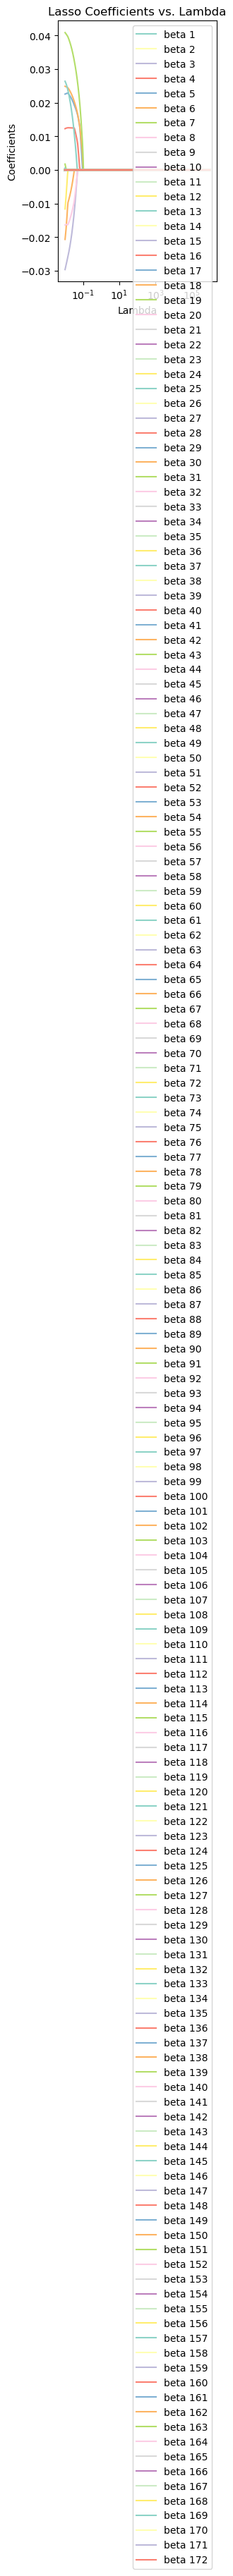

In [104]:
# lasso
plt.subplot(1, 2, 2)
for i in range(coefficients_lasso.shape[1]):
    plt.plot(alphas, coefficients_lasso[:, i], label=f'beta {i+1}')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs. Lambda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_df.loc[:, test_df.columns != 'upgraded_to_sub']

In [ ]:
model.fit(test_df['upgraded_to_sub',test_df.loc[:, test_df.columns != 'upgraded_to_sub']])

In [ ]:
x = sm.add_constant(df[['total_num_workouts','total_num_workout_days','top_instructor_capture']])

In [ ]:
model_workout_days = sm.Logit(y,x)

In [ ]:
print((model_workout_days.fit()).summary())

/var/folders/x9/4gknhlzx4ll0r30vtxwnht_c0000gp/T/ipykernel_76191/2762345061.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


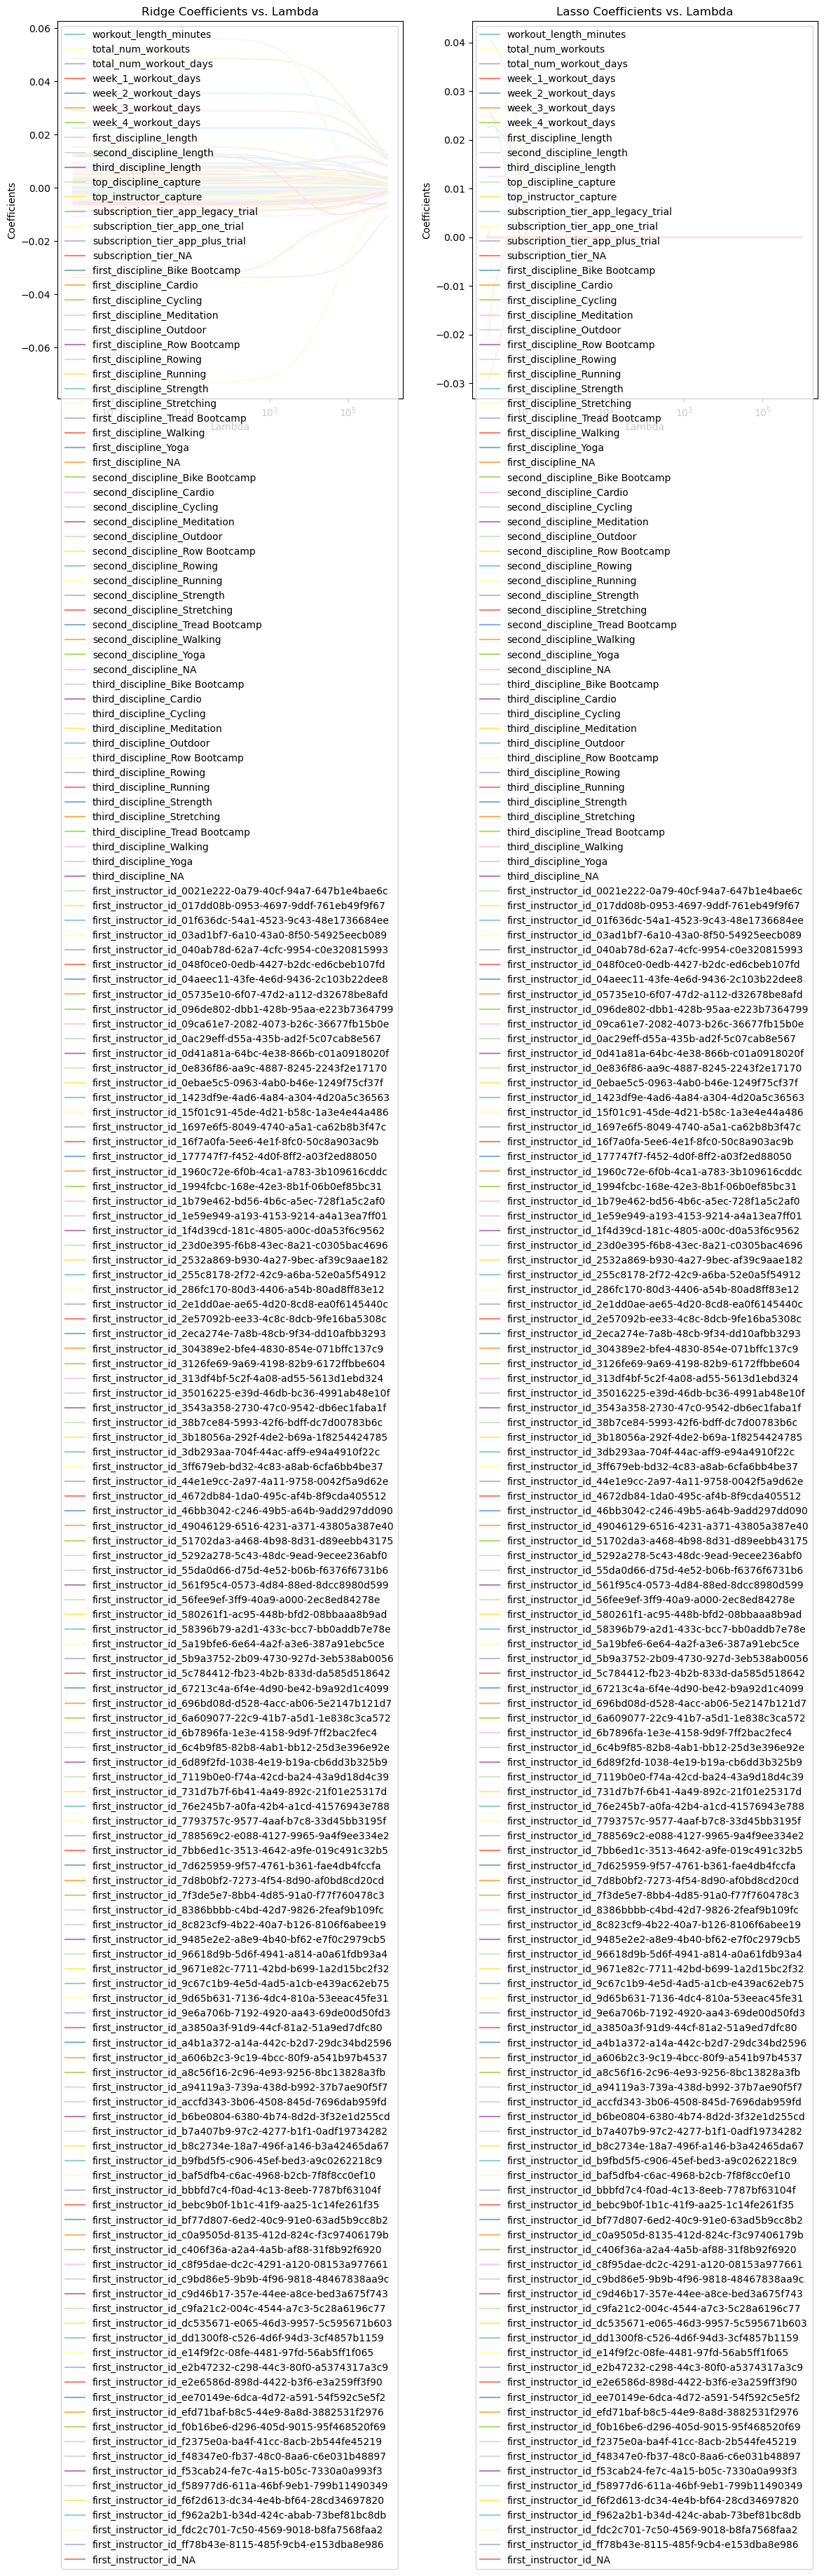

In [113]:
# plotting
plt.figure(figsize=(14, 7))

# ridge
plt.subplot(1, 2, 1)
for i in range(coefficients_ridge.shape[1]):
    plt.plot(alphas, coefficients_ridge[:, i], label=feature_names[i])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients vs. Lambda')
plt.legend()

# lasso
plt.subplot(1, 2, 2)
for i in range(coefficients_lasso.shape[1]):
    plt.plot(alphas, coefficients_lasso[:, i], label=feature_names[i])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs. Lambda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_standardized, y)
    coefficients_ridge.append(ridge.coef_)

    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_standardized, y)
    coefficients_lasso.append(lasso.coef_)
        for i, coef in enumerate(coefs):
        if coef == 0 and alpha_zero[feature_names[i]] == np.inf:
            alpha_zero[feature_names[i]] = alpha

In [100]:
# convert list of coefficients into a numpy array for easy plotting
coefficients_ridge = np.array(coefficients_ridge)
coefficients_lasso = np.array(coefficients_lasso)

In [108]:
coefficients_ridge

array([[ 0.00777849, -0.03612755, -0.00558561, ...,  0.00115565,
        -0.00127708,  0.0121954 ],
       [ 0.00777849, -0.03612755, -0.00558561, ...,  0.00115565,
        -0.00127708,  0.01219539],
       [ 0.00777849, -0.03612755, -0.00558561, ...,  0.00115565,
        -0.00127708,  0.01219539],
       ...,
       [ 0.00388415,  0.00375874,  0.00856843, ...,  0.00027118,
        -0.00015089, -0.00587243],
       [ 0.00392044,  0.00384189,  0.00844002, ...,  0.00025831,
        -0.00014506, -0.00576127],
       [ 0.00394965,  0.00391324,  0.00830687, ...,  0.00024589,
        -0.00013907, -0.00564971]])

In [106]:
coefficients_ridge.shape

(300, 172)

In [147]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

In [148]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7]},
             scoring='accuracy')

In [246]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5}


In [322]:
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Cross-Validation Score: 0.664046312003748


In [248]:
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [249]:
y_pred = xgbmodel.predict(X_test)

In [250]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6291079812206573
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      6530
           1       0.68      0.66      0.67      8593

    accuracy                           0.63     15123
   macro avg       0.62      0.62      0.62     15123
weighted avg       0.63      0.63      0.63     15123



In [251]:
importance = xgbmodel.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [252]:
# Output the ranked DataFrame
importance_df.head(10)

,Feature,Importance
2,total_num_workout_days,0.131014
0,workout_length_minutes,0.101456
6,week_4_workout_days,0.082759
12,subscription_tier_app_legacy_trial,0.066679
5,week_3_workout_days,0.060302
7,first_discipline_length,0.057921
14,subscription_tier_app_plus_trial,0.050355
13,subscription_tier_app_one_trial,0.045658
29,first_discipline_NA,0.018607
3,week_1_workout_days,0.017524
